<a href="https://colab.research.google.com/github/YolandaMDavis/cs109a-fall2020/blob/main/Milestone_3_EDA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

DATA_ROOT = '/content/drive/My Drive/Final-Project-for-CS109a/Milestone3/'
random_state = 109

In [3]:
new_york_crime_data_df = pd.read_csv(DATA_ROOT + 'nyc_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])
boston_crime_data_df = pd.read_csv(DATA_ROOT + 'boston_crime_analysis_data_final.csv').drop(columns=["Unnamed: 0"])

In [4]:
# Create Train/Test splits for Boston and New York Data
boston_crime_train, boston_crime_test = train_test_split(boston_crime_data_df, train_size=.8, random_state = random_state)
nyc_crime_train, nyc_crime_test = train_test_split(new_york_crime_data_df, train_size=.8, random_state = random_state)

#Combine Data Sets and split for Generalized Analysis
boston_crime_data_df["IS_BOSTON"] = np.ones(boston_crime_data_df.shape[0])
new_york_crime_data_df["IS_BOSTON"] = np.zeros(new_york_crime_data_df.shape[0])
combined_crime_data_df = pd.concat([boston_crime_data_df, new_york_crime_data_df])
comb_crime_train, comb_crime_test = train_test_split(combined_crime_data_df, train_size=.8, random_state = random_state)

**Data Visualization and Analysis**

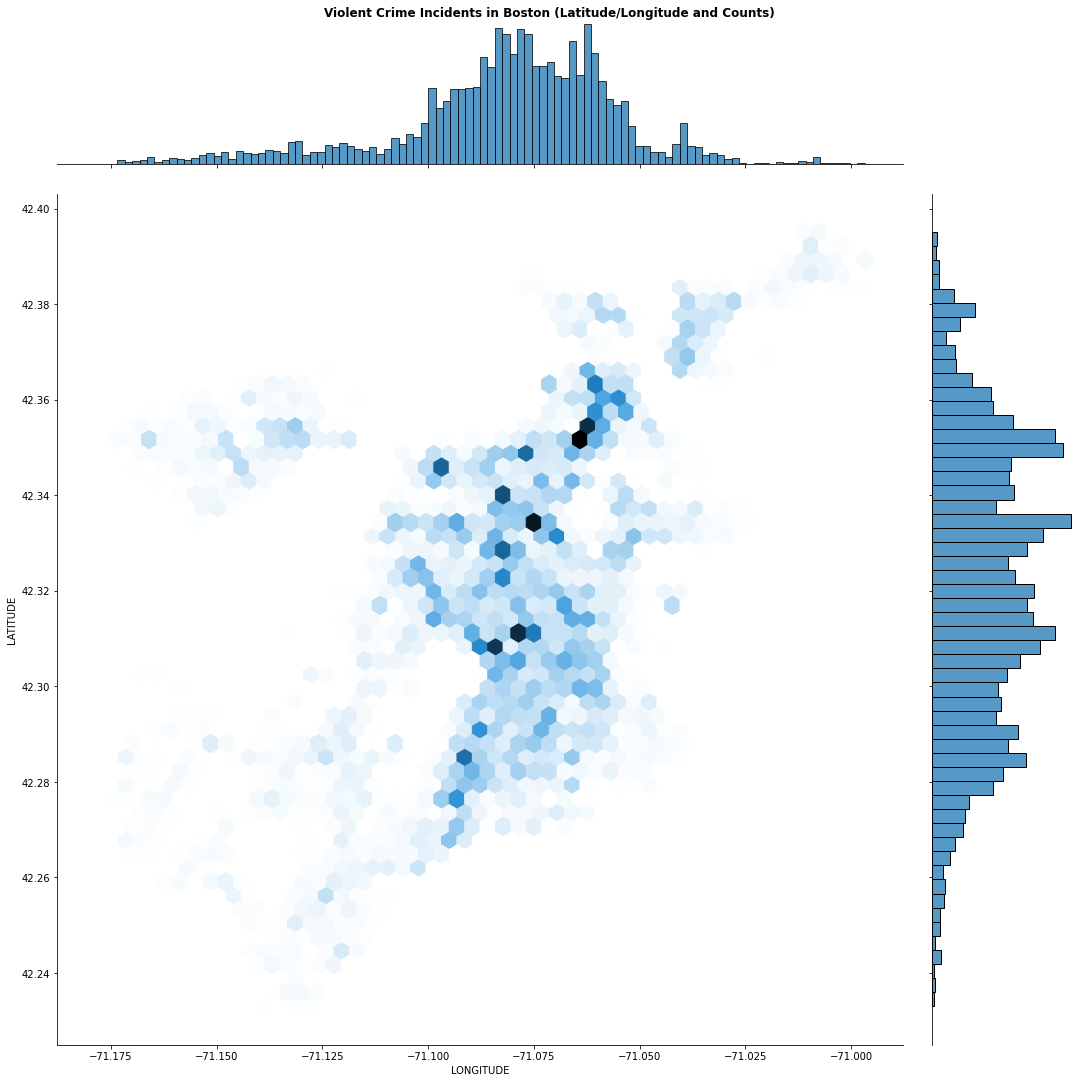

In [26]:
# Positional Plot of Violent Crime Occurence in Boston
violent_crime = boston_crime_train.loc[boston_crime_train['VIOLENT_CRIME']== 1]
sns.jointplot(x='LONGITUDE',y='LATITUDE',data=violent_crime,kind='hex', height=15)
plt.suptitle('Violent Crime Incidents in Boston (Latitude/Longitude and Counts)', y=1, fontsize=12, fontweight="bold")
plt.show()

In Boston violent crime appears to be more centrallly focused in the region.

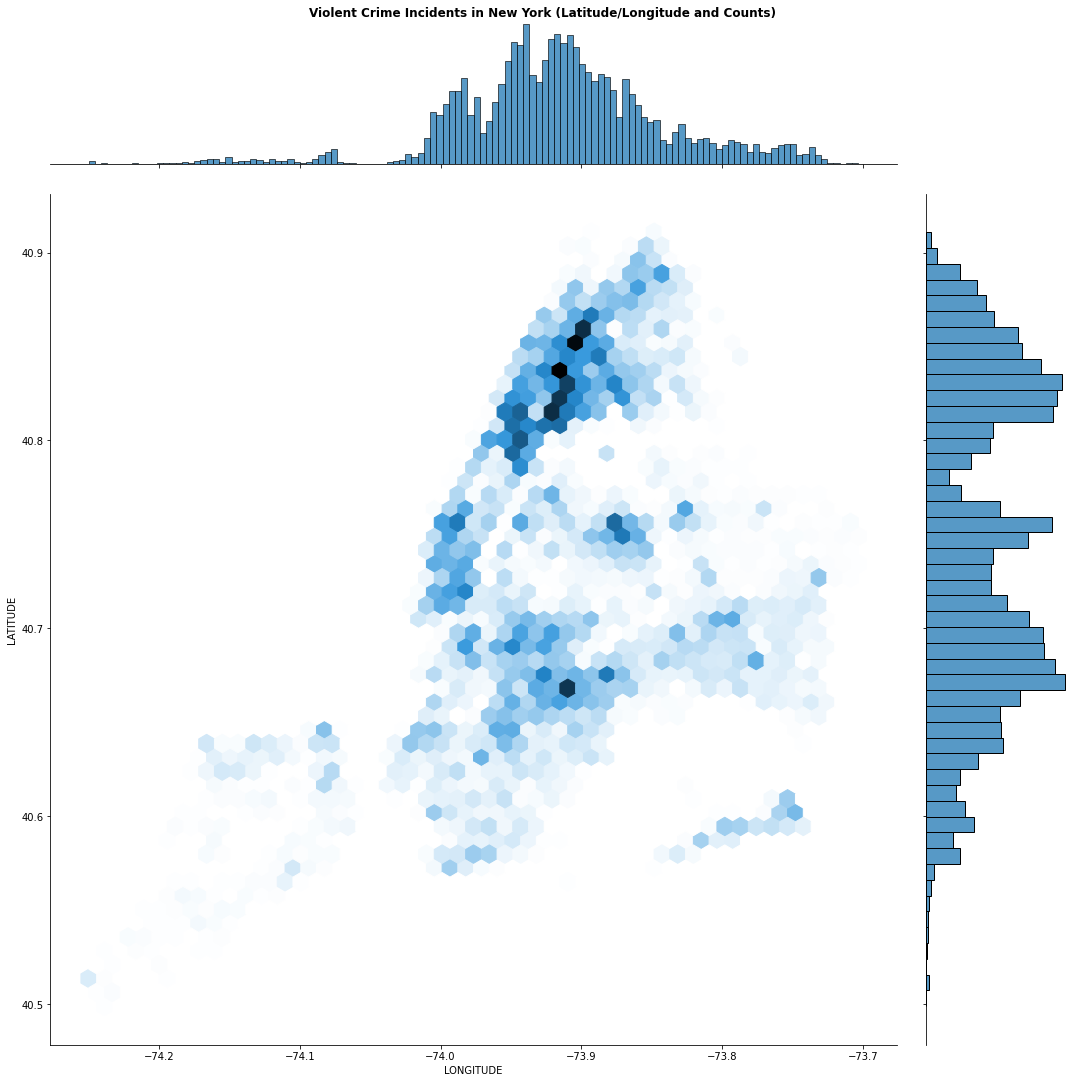

In [28]:
# Positional Plot of Violent Crime Occurence in New York
violent_crime = nyc_crime_train.loc[nyc_crime_train['VIOLENT_CRIME']== 1]
sns.jointplot(x='LONGITUDE',y='LATITUDE',data=violent_crime,kind='hex', height=15)
plt.suptitle('Violent Crime Incidents in New York (Latitude/Longitude and Counts)', y=1, fontsize=12, fontweight="bold")
plt.show()

In the New York plot we see higher incidence of violent crime occuring the higher latitude and longitude position of the graph (mostly in the north east region of the city). Lower incidence of violent crime appears on the south western areas.

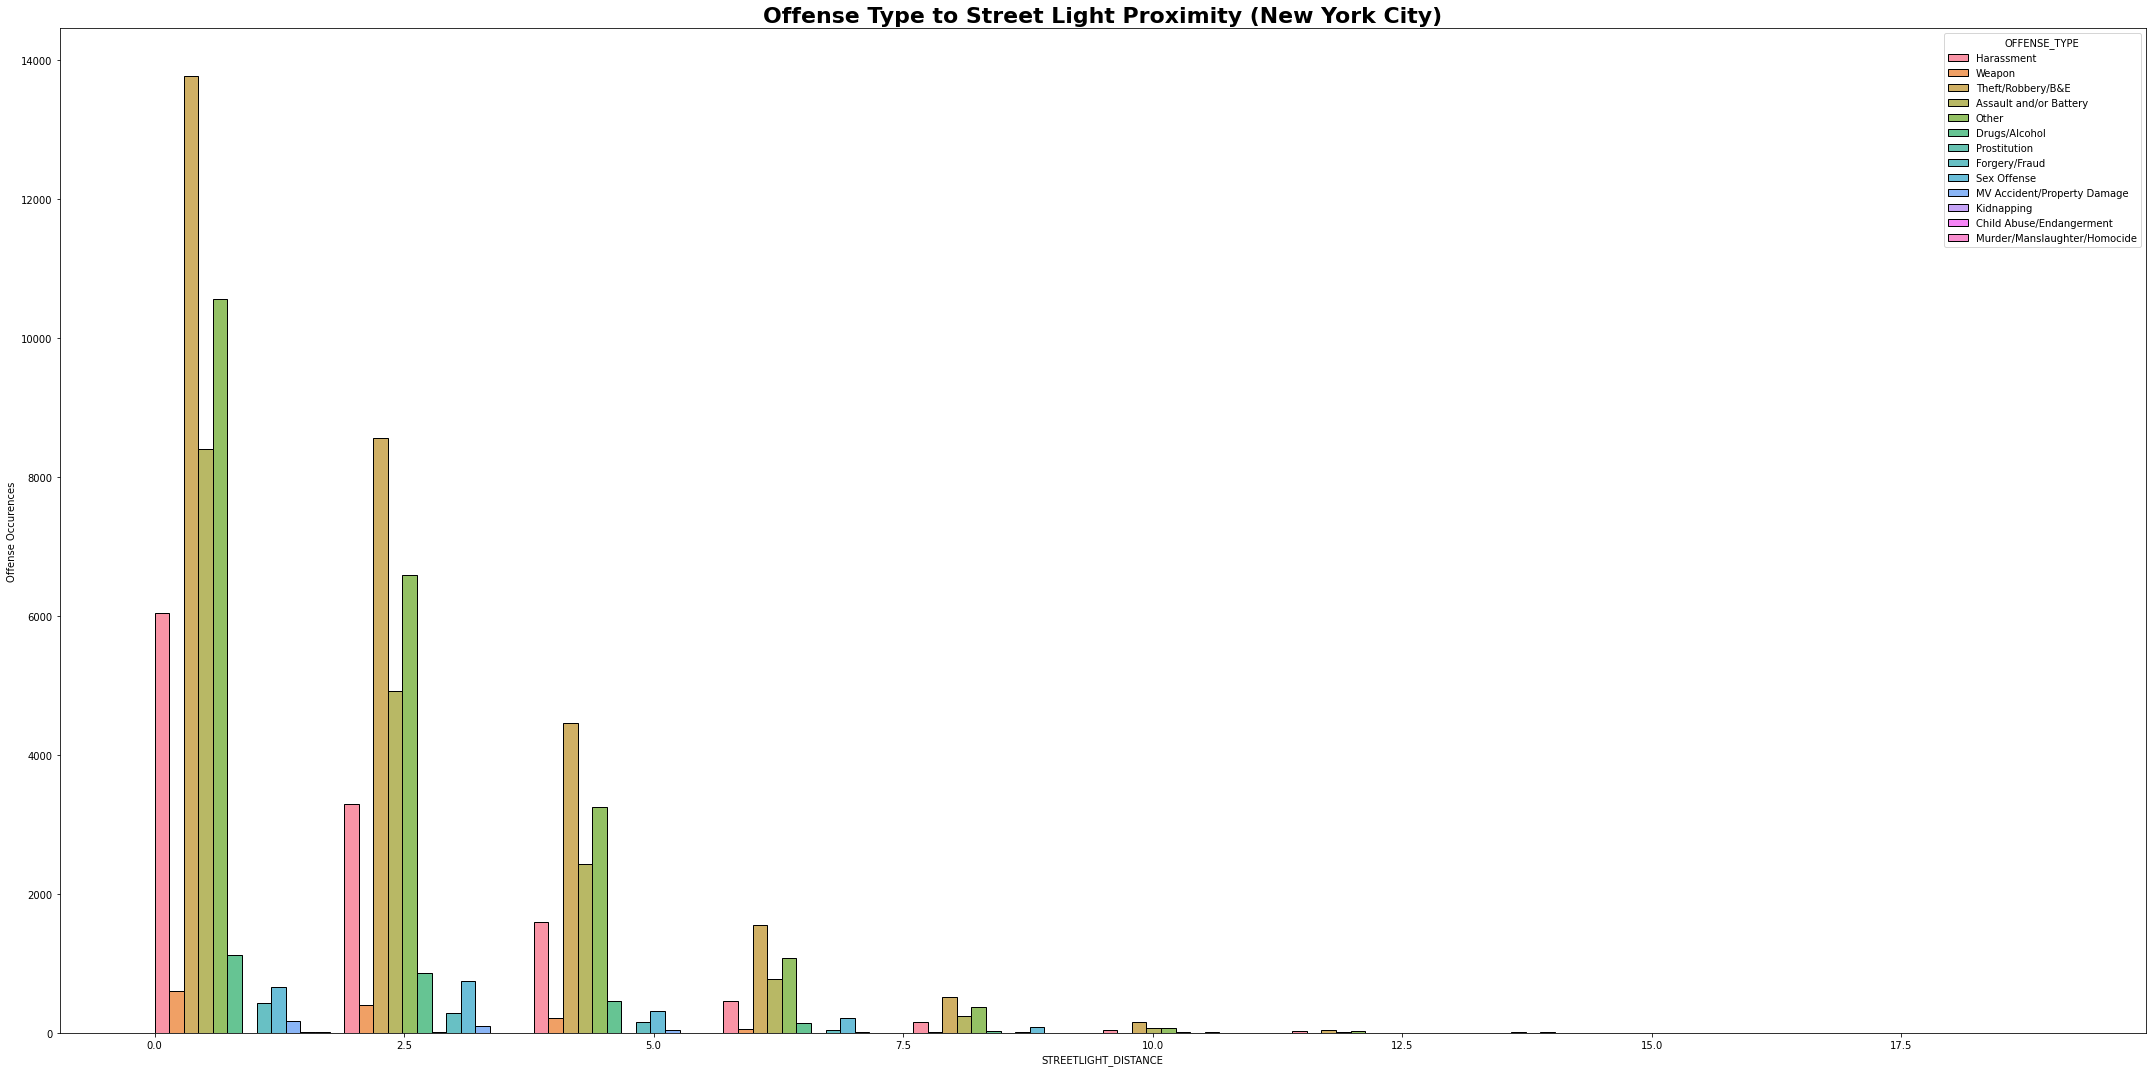

In [34]:
import matplotlib.ticker as ticker

# We want to understand the impact of street lights at night on crime incidence by offense type
# Get all offencses that occur at night and select the street light distance from the offense
interaction_night_nyc=nyc_crime_train[nyc_crime_train.NIGHT == 1]['STREETLIGHT_DISTANCE']

fig, ax = plt.subplots(1,figsize=(30,15),sharey=False)
sns.histplot(nyc_crime_train,x=interaction_night_nyc, color='y', ax=ax ,multiple="dodge", hue="OFFENSE_TYPE",bins=10,)

ax.set_title('Offense Type to Street Light Proximity (New York City)',fontdict={ 'weight' : 'bold',
        'size'   : 22})
ax.set_ylabel("Offense Occurences")
plt.tight_layout()
plt.show()

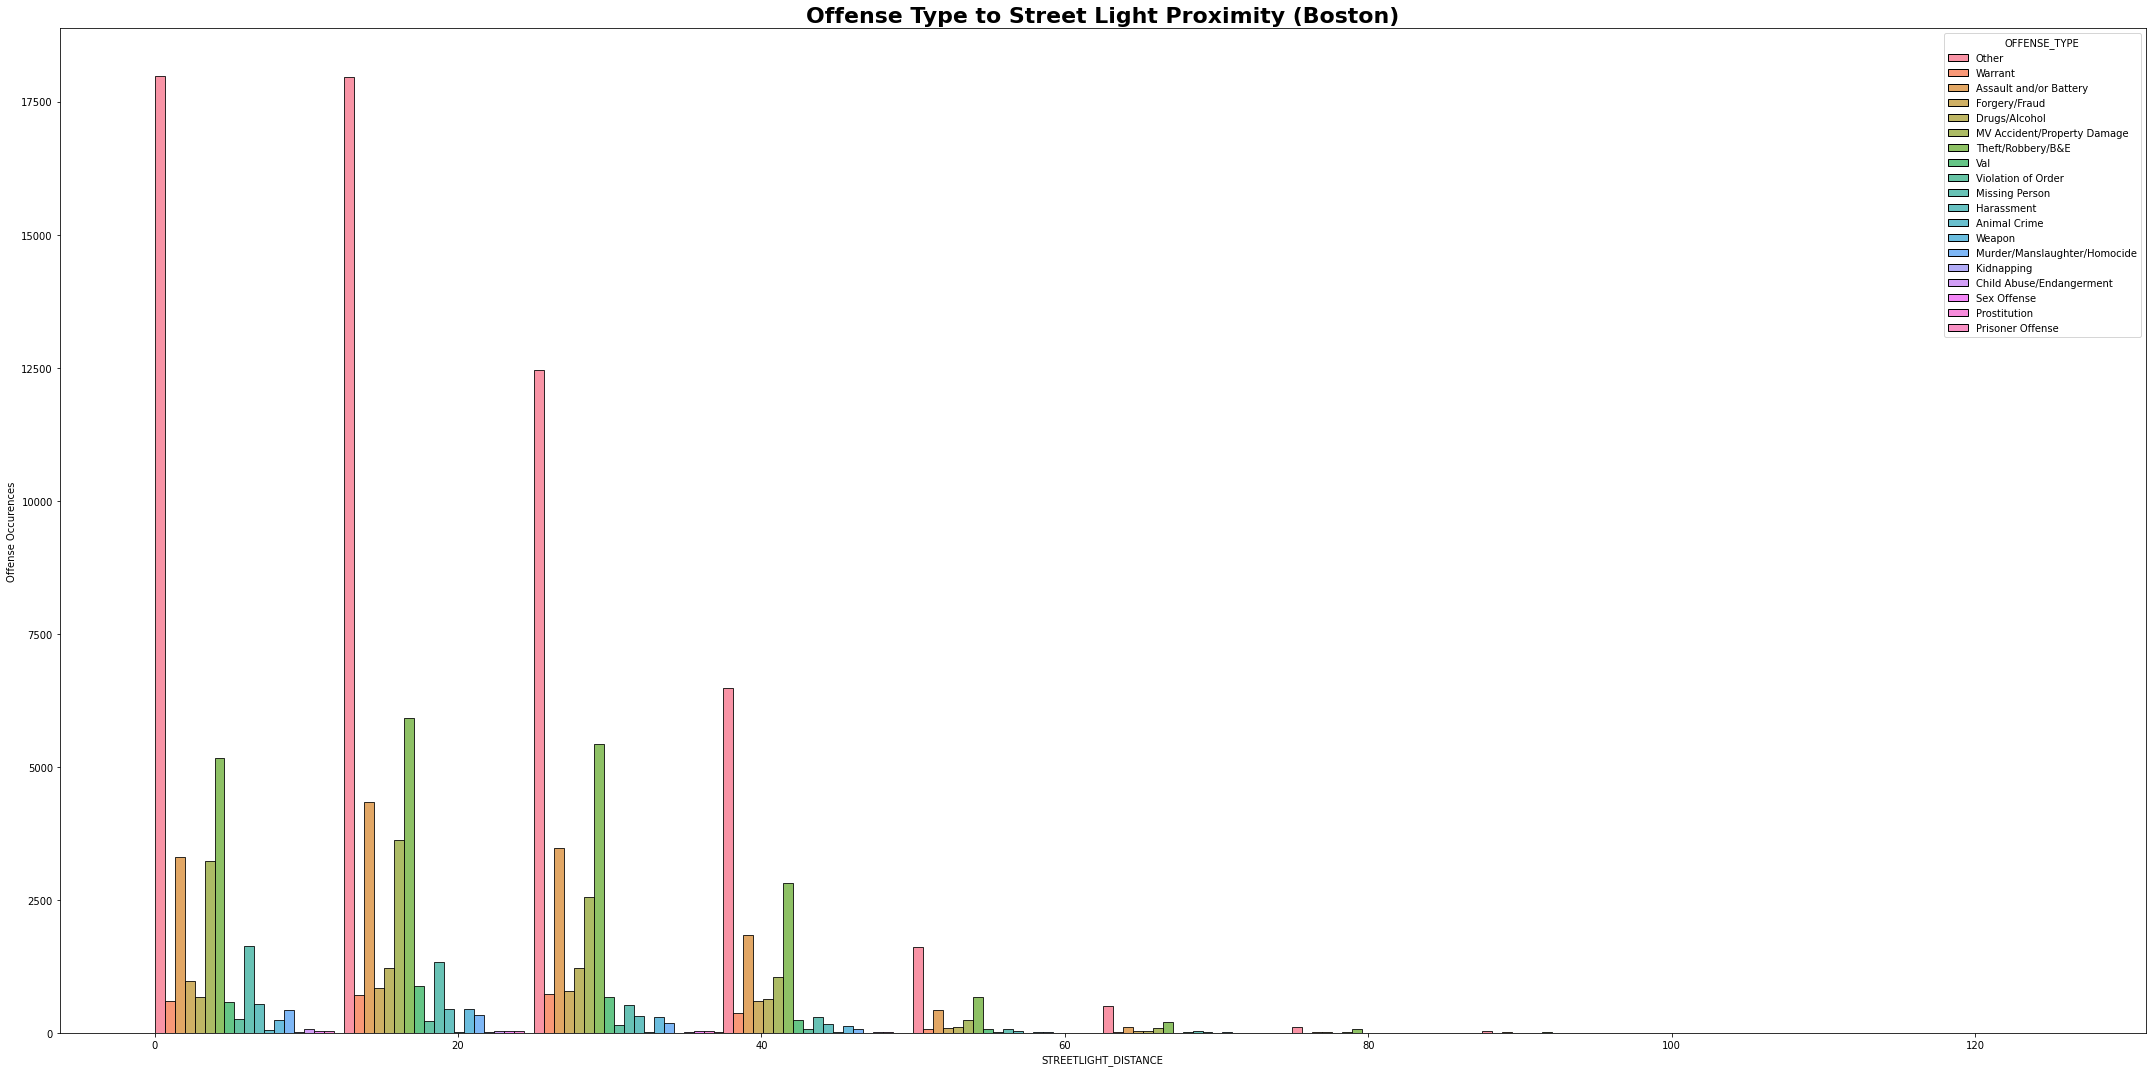

In [37]:
# We want to understand the impact of street lights at night on crime incidence by offense type
# Get all offenses that occur at night and select the street light distance from the offense
interaction_night_boston=boston_crime_train[boston_crime_train.NIGHT == 1]['STREETLIGHT_DISTANCE']
fig, ax = plt.subplots(1,figsize=(30,15),sharey=False)
sns.histplot(boston_crime_train,x=interaction_night_boston, color='y', ax=ax ,multiple="dodge", hue="OFFENSE_TYPE",bins=10,)
ax.set_title('Offense Type to Street Light Proximity (Boston)',fontdict={ 'weight' : 'bold','size'   : 22})
ax.set_ylabel("Offense Occurences")
plt.tight_layout()
plt.show()

The above does show some instance of less crimes of a certain type occuring near street lights.  In the above, incidents of assault and battery and theft appear to have lower occurence when comparing between the 0 and 20 distance marker.  However as we move further out beyond 20 there is an overall decrease, which may be due to more rural/surburban areas which have overall less crime.

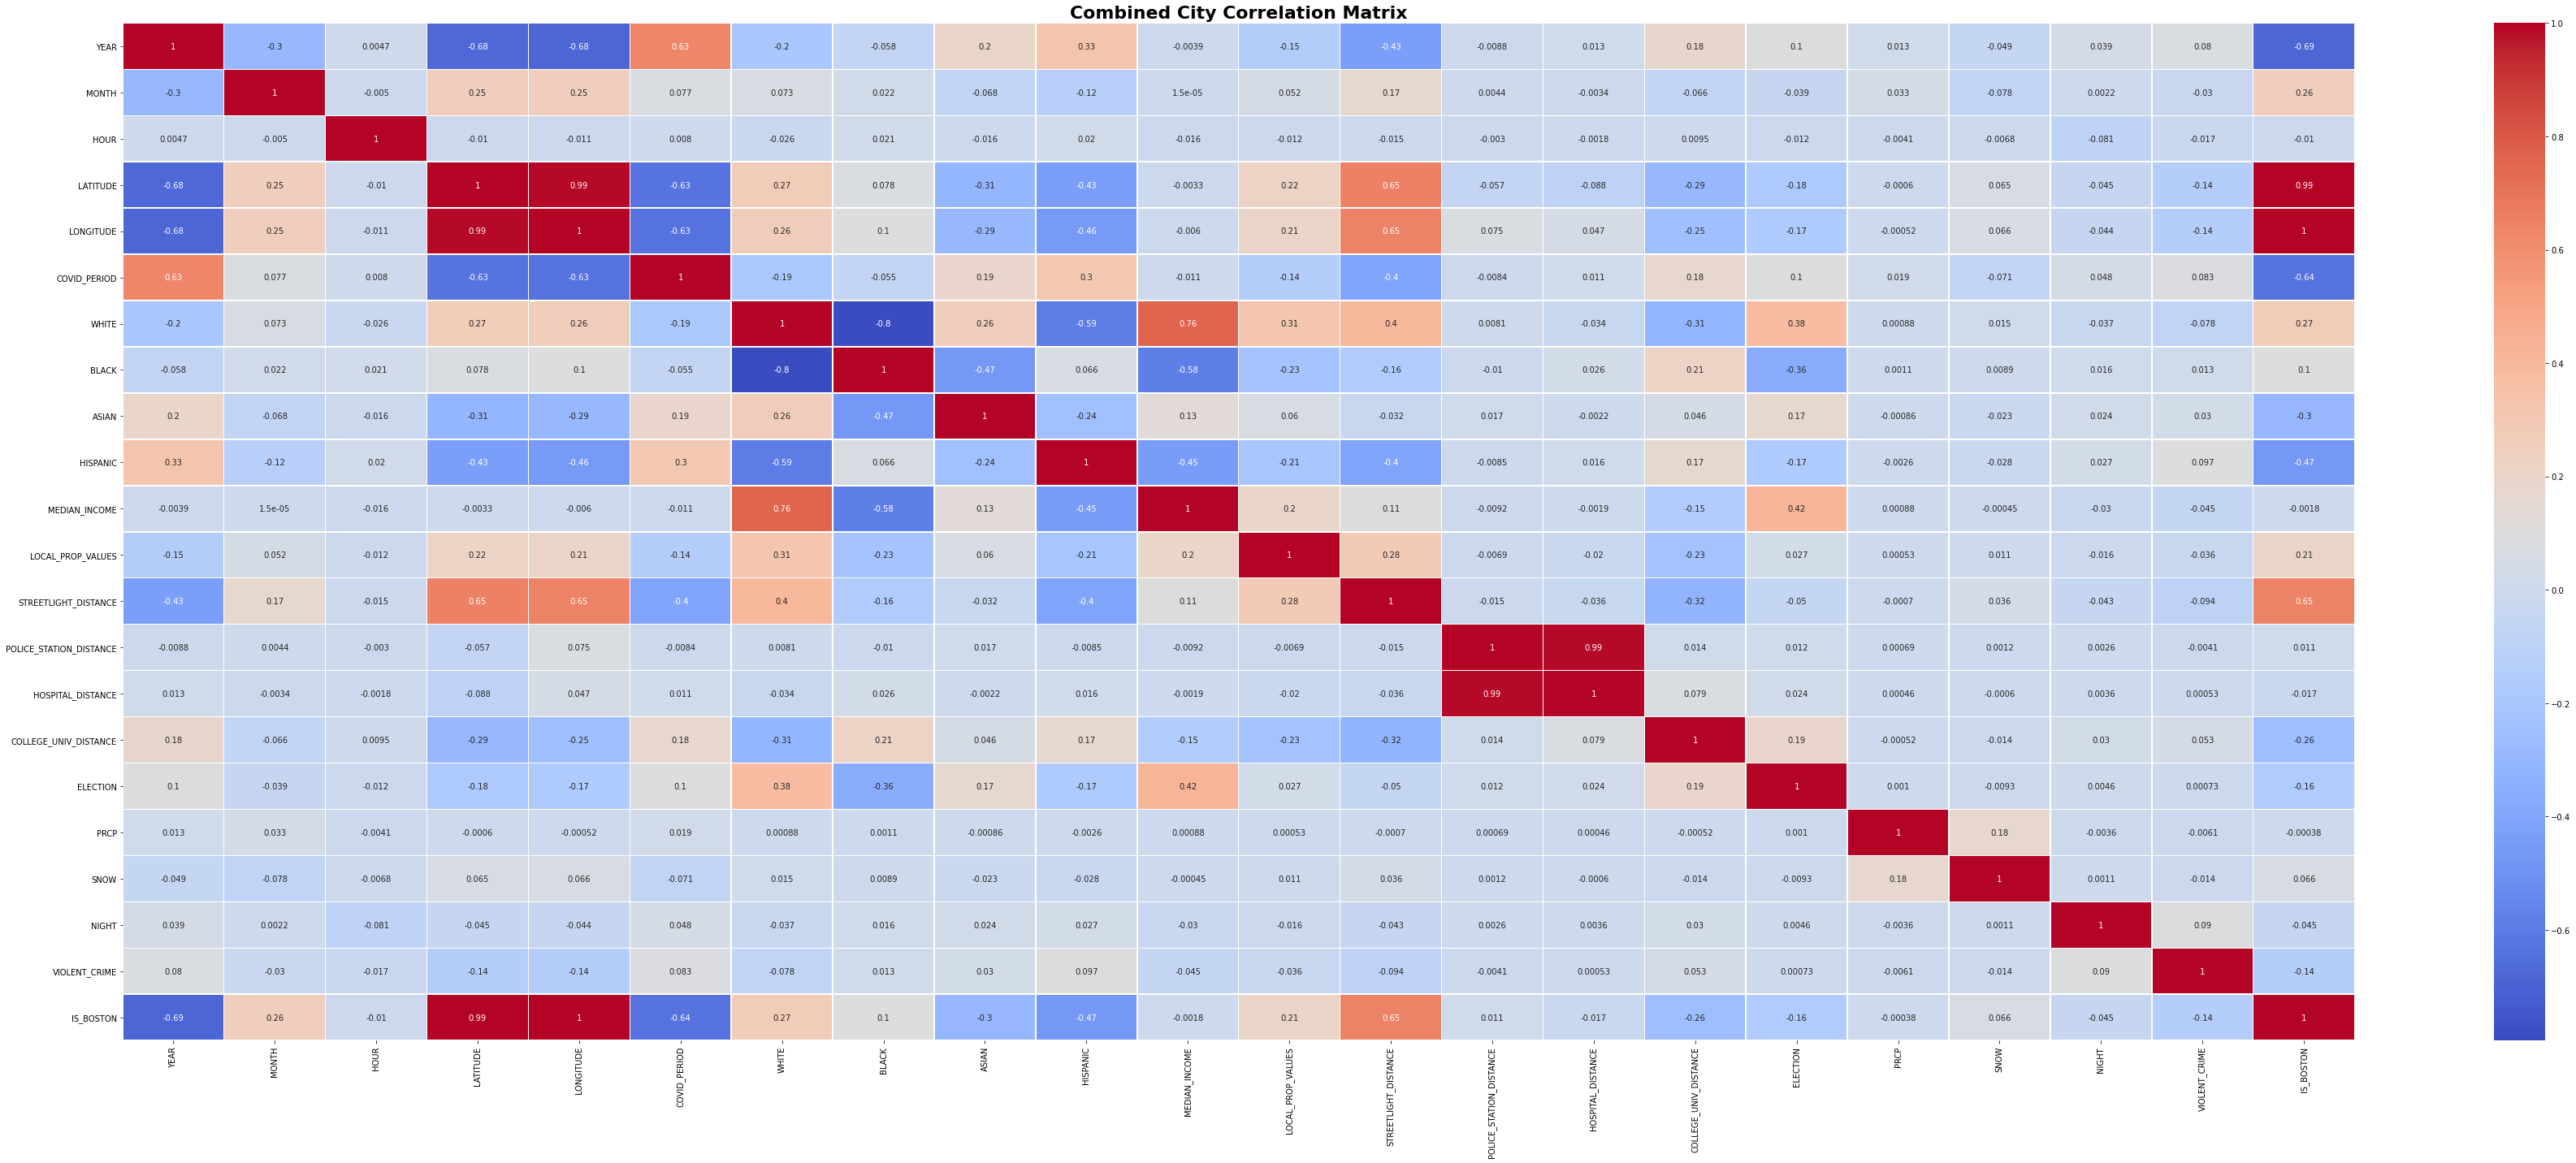

In [8]:
# Combined City Correlation Matrix - Violent Crime
comb_corr = comb_crime_train.corr()
fig, ax = plt.subplots(figsize=(50,20)) 
ax = sns.heatmap(comb_corr, annot=True, cmap='coolwarm', linewidths=.5)
ax.set_title("Combined City Correlation Matrix - Violent Crime", fontdict={ 'weight' : 'bold',
        'size'   : 22})
plt.tight_layout()

When looking at the combined cities, Other than for location, violent crime does not appear to have strong correlation with most indcators however there are some small correlations of note with COVID Period, Street light distance,Hispanic, and Night.


Text(0.5, 1.0, 'Combined City Correlation Matrix - Offense Types')

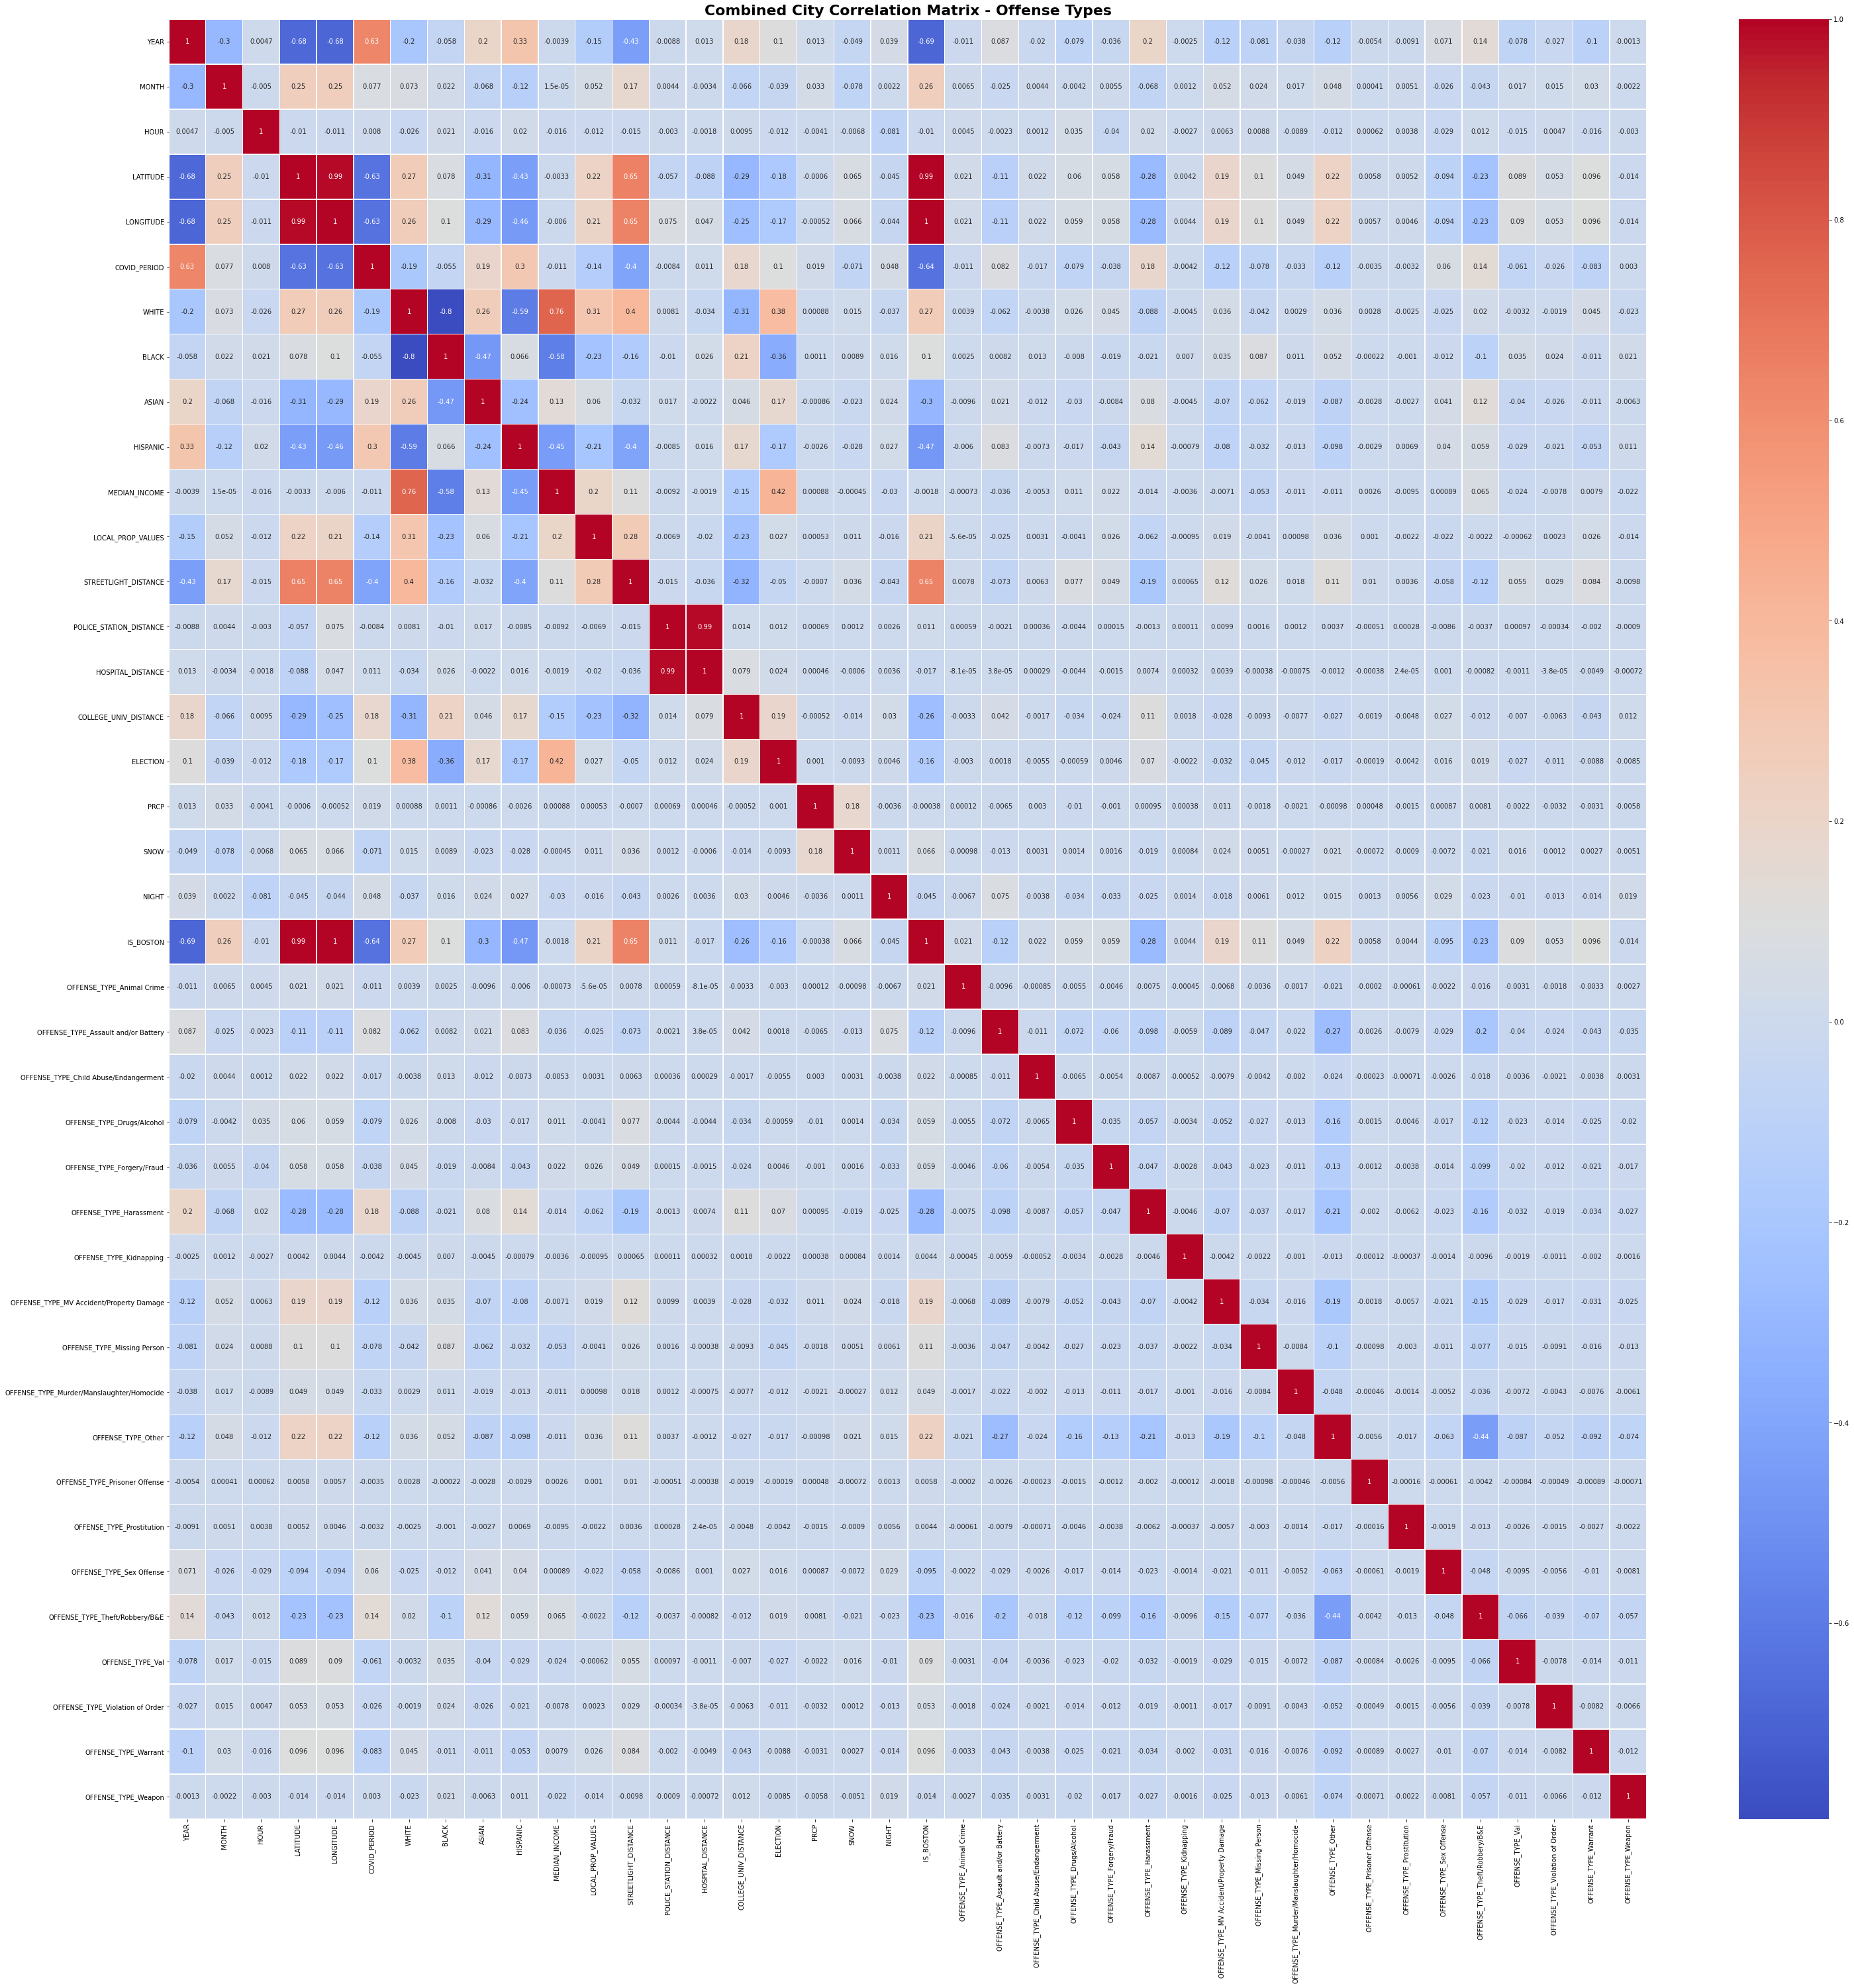

In [10]:
demog_category_columns = ['OFFENSE_TYPE']
comb_crime_dummies_df = pd.get_dummies(comb_crime_train, columns=demog_category_columns)
comb_corr = comb_crime_dummies_df.drop(columns=['VIOLENT_CRIME']).corr()
fig, ax = plt.subplots(figsize=(50,50)) 
ax = sns.heatmap(comb_corr, annot=True, cmap='coolwarm', linewidths=.5)
ax.set_title("Combined City Correlation Matrix - Offense Types", fontdict={ 'weight' : 'bold',
        'size'   : 22})
plt.tight_layout()

When breakdown by offense type, there still appears to be small correlations location still appears to be a standout.  Also the correlation with latitude, longitude and is_boston indicator shows perhaps 1 predictor from the 3 would be sufficient in predictor.  Interesting correlations to note are those for Median Income for Theft / Robbery / Breaking and Entering, which is not suprising.  A negative correlation with Murder/Homocide appears to show during COVID period. Night time also appears to have noted affects on Assault and Drugs/Alcohol offenses. Overall however these correlations are fairly small.

**Baseline Model - Violent Crime Prediction**

In [5]:
# Naive Model - Boston Classification Accuracy for Violent Crime
train_offenses = boston_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = boston_crime_train[boston_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = boston_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = boston_crime_test[boston_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime in Boston: {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime in Boston: 0.082
Naive Model Train Accuracy when classifying all offenses as not violent: 0.918
Naive Model Test Accuracy when classifying all offenses as not violent: 0.918


In [6]:
# Naive Model - New York Classification Accuracy for Violent Crime
train_offenses = nyc_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = nyc_crime_train[nyc_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = nyc_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = nyc_crime_test[nyc_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (NYC) : {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime (NYC) : 0.176
Naive Model Train Accuracy when classifying all offenses as not violent: 0.824
Naive Model Test Accuracy when classifying all offenses as not violent: 0.824


In [7]:
# Naive Model - Combined City Classification Accuracy for Violent Crime
train_offenses = comb_crime_train['VIOLENT_CRIME'].count()
train_violent_crime = comb_crime_train[comb_crime_train["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
train_proportion_violent = round(train_violent_crime/train_offenses, 3)
train_accuracy = round(1 - train_proportion_violent,3)

test_offenses = comb_crime_test['VIOLENT_CRIME'].count()
test_violent_crime = comb_crime_test[comb_crime_test["VIOLENT_CRIME"] == 1]['VIOLENT_CRIME'].sum()
test_proportion_violent = round(test_violent_crime/test_offenses, 3)
test_accuracy = round(1 - test_proportion_violent,3)

print(f"Proportion of violent crime (Combined) : {train_proportion_violent}")
print(f"Naive Model Train Accuracy when classifying all offenses as not violent: {train_accuracy}")
print(f"Naive Model Test Accuracy when classifying all offenses as not violent: {test_accuracy}")

Proportion of violent crime (Combined) : 0.118
Naive Model Train Accuracy when classifying all offenses as not violent: 0.882
Naive Model Test Accuracy when classifying all offenses as not violent: 0.882
